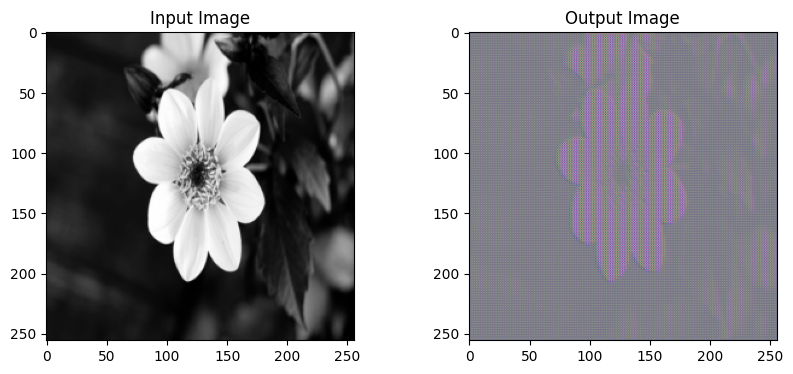

In [3]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch
from torch import nn

class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.down1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)
        self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.down3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.down4 = nn.Conv2d(256, 512, 3, stride=2, padding=1)

        self.up1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1)
        self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1, output_padding=1)
        self.up3 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1)
        self.up4 = nn.ConvTranspose2d(128, 3, 3, stride=2, padding=1, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        d1 = self.relu(self.down1(x))
        d2 = self.relu(self.down2(d1))
        d3 = self.relu(self.down3(d2))
        d4 = self.relu(self.down4(d3))

        u1 = self.relu(self.up1(d4))
        u2 = self.relu(self.up2(torch.cat((u1, d3), dim=1)))
        u3 = self.relu(self.up3(torch.cat((u2, d2), dim=1)))
        u4 = self.sigmoid(self.up4(torch.cat((u3, d1), dim=1)))

        return u4

# Load the model
model = torch.load('model.pth')
model.eval()  # set the model to evaluation mode

new_gray_img = Image.open('flower.jpg')

new_gray_img = new_gray_img.convert('L')

transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
])

new_gray_img = transform(new_gray_img).unsqueeze(0)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available
new_gray_img = new_gray_img.to(DEVICE)
model = model.to(DEVICE)

import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    output = model(new_gray_img)
    output_image = output.cpu().squeeze().numpy()

input_image = new_gray_img.cpu().squeeze().numpy()
output_image = np.transpose(output_image, (1, 2, 0))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(output_image, cmap='gray')
plt.title('Output Image')

plt.show()